<a href="https://colab.research.google.com/github/IoPapadopoulos/ttbar_analysis/blob/main/ttbar_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**How to Rediscover the Top-Antitop $t\bar{t}$ Quark Pair Production Yourself!**

This notebook uses ATLAS Open Data to guide you through the steps needed to rediscover the production of top-antitop quark pairs $t\bar{t}$ in high-energy proton-proton collisions at the Large Hadron Collider (LHC).

ATLAS Open Data provides open access to proton-proton collision data collected by the ATLAS experiment at the LHC. These datasets are made available for educational purposes, making them ideal for high-school, undergraduate, and postgraduate students interested in learning about particle physics.

# **What Are Notebooks?**

Notebooks are interactive web applications that allow you to create and share documents that contain:

1. **Live code:** Write and execute code in real-time, making adjustments as you go.

2. **Visualizations:** Create plots, histograms, and other graphical representations of your data to better understand the underlying physics.

3. **Narrative text:** Include explanations, descriptions, and commentary to guide yourself or others through the analysis.


# **The Goal: Rediscovering $t\bar{t}$ Production**

By following this notebook, you will perform a $t\bar{t}$ analysis, aiming to identify and study the production of top-antitop quark pairs. The process involves applying a series of selection cuts and analysis techniques to increase the ratio of signal (events where $t\bar{t}$ pairs are produced) to background (other processes that can mimic the signal).

A key part of this analysis is focusing on the semileptonic decay of the $t\bar{t}$ pair. In this decay mode, one top quark decays into a W boson and a b-quark, with the W boson further decaying into a charged lepton and a neutrino, while the other top quark decays hadronically (into jets).This can be represented as:
* $ t\bar{t} \rightarrow lvb\bar{b}q\bar{q}$

where:

* $l$ is a lepton,
* $v$ is a neutrino,
* $b$ is a b-tagged jet,
* $q$ is a jet.


**Contents:**
* Running a Jupyter notebook
* To setup
* Explanation of Key Parameters in the $t\bar{t}$ Analysis Code
* Samples
* Weight in Particle Physics Analysis
* Introduction to Event Selection Cuts in $t\bar{t}$ Analysis
* Introduction to Mass Reconstruction in $t\bar{t}$ Analysis
* Data Processing and Event Selection Function
* Data Retrieval in $t\bar{t}$ Analysis
* Data Processing
* Data Aggregation with Loops
* Combining Mass and Weight Lists
* Plotting


# **Running a Jupyter notebook**
To run the whole Jupyter notebook, in the top menu click Cell -> Run All.

To propagate a change you've made to a piece of code, click Cell -> Run All Below.

You can also run a single code cell, by clicking Cell -> Run Cells, or using the keyboard shortcut Shift+Enter.


In [ ]:
!pip install uproot

# **To setup**
Cell -> Run All Below

to be done every time you re-open this notebook

We're going to be using a number of tools to help us:

* uproot: lets us read .root files typically used in particle physics into data formats used in python
* awkward: lets us use efficiently the nested data in columnar format
* pandas: lets us store data as dataframes, a format widely used in python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations
lmfit: tool for statistical fitting

In [49]:
import uproot  # For reading ROOT files efficiently

import awkward as ak  # To represent nested data in columnar format
import numpy as np  # For numerical calculations such as histogramming
import pandas as pd


import matplotlib.pyplot as plt  # For creating plots and visualizations
from matplotlib.ticker import AutoMinorLocator  # For adding minor ticks to plot axes

import requests  # For making HTTP requests

import time  # For timing operations and adding delays if needed
import warnings

warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")
warnings.filterwarnings("ignore", message="overflow encountered in power")
warnings.filterwarnings("ignore", message="overflow encountered in multiply", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in subtract")

# **Explanation of Key Parameters in the $t\bar{t}$ Analysis Code**

In particle physics analyses, various parameters and constants are essential for accurately processing data and interpreting results. Below is an explanation of the key parameters used in the
 $t\bar{t}$ analysis code provided:

1.   **Integrated Luminosity (lumi)**

  *   Definition: Integrated luminosity is a measure of the total amount of data collected by a particle detector over a certain period. It represents the total number of potential collisions that could have occurred in a particle accelerator and is typically measured in inverse femtobarns fb$^{-1}$.

2. **Fraction of Events to Process**

  *   Definition: This parameter controls what fraction of the available events in the dataset will be processed by the analysis.

3. **Conversion Factor from MeV to GeV**

  * Definition: Particle physics often uses energy units like MeV (Mega electron Volts) and GeV (Giga electron Volts). The conversion factor helps switch between these units.

4. **Minimum Transverse Momentum $p_𝑇$ Limit Definition**
  * Transverse momentum $p_𝑇$ is a crucial quantity in particle physics, representing the momentum of particles perpendicular to the beam axis. It's often used as a selection criterion for events.

5. **MV2c10 b-Tagging Algorithm Discriminant Cut Value Definition**
  * The MV2c10 is a b-tagging algorithm used to identify jets originating from b-quarks. The discriminant cut value determines the threshold for tagging a jet as a b-jet.

  For further information visit [atlas glossary](https://atlas.cern/glossary)





In [50]:
# Integrated luminosity in inverse femtobarns
lumi = 10000.

# Fraction of events to process
fraction = 0.1

# Conversion factor from MeV to GeV
MeV2GeV = 0.001

# Minimum transverse momentum (pT) limit in GeV
pt_lim = 30

# MV2c10 b-tagging algorithm discriminant cut value
MV2c10_lim = 0.828

# **Samples**
Samples to process

In [51]:
# Dictionary of samples to be processed
samples = {
    # Real data samples
    'data_A': {'list' : ['data_A'],},
    'data_B': {'list' : ['data_B'],},
    'data_C': {'list' : ['data_C'],},
    'data_D': {'list' : ['data_D'],},

    # Main Monte Carlo (MC) sample: top quark pair production
    'ttbar' : {  'list' : ['mc_410000.ttbar_lep'],},

    # Single top quark production samples
    'Single top' : {  'list' : [
        'mc_410011.single_top_tchan',      # t-channel single top
        'mc_410012.single_antitop_tchan',  # t-channel single anti-top
        'mc_410013.single_top_wtchan',     # Wt-channel single top
        'mc_410014.single_antitop_wtchan', # Wt-channel single anti-top
        'mc_410025.single_top_schan',      # s-channel single top
        'mc_410026.single_antitop_schan'   # s-channel single anti-top
        ],},

    # Diboson production samples
    'Diboson' : {  'list' : [
        'mc_363356.ZqqZll',    # Z(qq)Z(ll)
        'mc_363358.WqqZll',    # W(qq)Z(ll)
        'mc_363359.WpqqWmlv',  # W+(qq)W-(lv)
        'mc_363360.WplvWmqq',  # W+(lv)W-(qq)
        'mc_363359.WpqqWmlv',  # W+(qq)W-(lv)
        'mc_363360.WplvWmqq',  # W+(lv)W-(qq)
        'mc_363489.WlvZqq'     # W(lv)Z(qq)
         ],},
        }

# **Weight in Particle Physics Analysis**

In particle physics analysis, such as in the study of the production of top-antitop quark pairs $t\bar{t}$, the concept of "weight" plays a crucial role. Weights are factors applied to events or data points in a dataset to ensure that the results of an analysis accurately reflect the underlying physics being studied. These weights account for various factors, including the efficiencies of detectors, the probability of certain processes occurring, and the corrections needed to match the simulated data with real-world observations.

The following function computes the event weights by combining several correction factors, including trigger efficiencies, pileup corrections, b-tagging efficiencies, and cross-sections. The result is a set of weights that accurately reflect the likelihood and significance of each event, ensuring that the final analysis properly accounts for all relevant physical and experimental considerations.

In [52]:
def calc_weight(data):
    # Calculate the common scale factor
    scale = (data["scaleFactor_LepTRIGGER"] * data["scaleFactor_PILEUP"] * data["scaleFactor_BTAG"] *
             (data["mcWeight"] / data["SumWeights"]) * (data["XSection"] * lumi))

    # Calculate the scaleFactorE and scaleFactorM
    scaleFactorE = data["scaleFactor_ELE"] * scale
    scaleFactorM = data["scaleFactor_MUON"] * scale

    # Create boolean masks based on conditions
    e_condition = data["trigE"] & (data["mcWeight"] != 0.0)

    # Use boolean masks to select relevant entries from scaleFactorE and scaleFactorM
    weight_list = ak.where(e_condition, scaleFactorE, scaleFactorM)

    return weight_list

# **Introduction to Event Selection Cuts in $t\bar{t}$ Analysis**

In particle physics, particularly in the analysis of top-antitop $t\bar{t}$ quark pair production, the process of event selection is crucial for isolating the signal from the background. The goal is to apply a series of cuts, or selection criteria, that filter out events unlikely to be associated with the $t\bar{t}$ process, leaving a dataset enriched with signal events. These cuts are based on specific physical properties of the events, such as the presence and characteristics of leptons, missing transverse energy $E^{miss}_{T}$, and jets.

Each cut is designed to enhance the signal-to-background ratio, which is essential for making a clear observation of the $t\bar{t}$ signal. Below is an overview of the key cuts applied in this analysis:

1. **Trigger Selection:**
  * The first step in the analysis is to ensure that the events under consideration have fired the appropriate triggers.
  * Purpose: This cut checks whether either the electron trigger ('trigE') or the muon trigger ('trigM') has been activated. If either trigger fired, the event is considered for further analysis.

In [53]:
def cut_trig(trigE, trigM):
    # Return True if either electron or muon trigger fired
    return trigE | trigM

2. **Single Lepton Requirement:**
  * To focus on events characteristic of $t\bar{t}$ decays, we require exactly one lepton (electron or muon) in the event.
  * Purpose: This cut ensures that the event contains precisely one lepton, which is typical in semileptonic $t\bar{t}$ decays where one top quark decays leptonically, and the other decays hadronically.

In [54]:
def one_lep(lep_n):
    # Return True if exactly one lepton in the event
    return lep_n == 1

3. **Lepton Transverse Momentum ($p_𝑇$) Cut:**
  * High transverse momentum leptons are a key feature of $t\bar{t}$ events.
  * Purpose: This cut selects events where the transverse momentum of the lepton is above 30 GeV, ensuring that only significant lepton candidates are considered.

In [55]:
def cut_lep_pt(lep_pt):
    # Return True if lepton pT is above 30 GeV and save a list of the lepton pT in GeV
    Cut = lep_pt * MeV2GeV >= pt_lim
    return Cut

4. **Missing Transverse Energy ($E^{miss}_{T}$) Cut:**

  * $t\bar{t}$ events often have significant missing transverse energy due to the neutrinos produced in the decay.
  * Purpose: This cut selects events where the missing transverse energy is greater than 30 GeV, helping to reduce background from processes without significant $E^{miss}_{T}$.


In [56]:
def cut_met_et(met_et):
    # Return True if missing ET is above 30 GeV and save a list of the missing ET in GeV
    Cut = met_et * MeV2GeV >= 30
    return Cut

5. **W Boson Transverse Mass  ($M^{W}_{T}$) Cut:**
  * The transverse mass of the W boson, reconstructed from the lepton transverse momentum and $E^{miss}_{T}$.
  * Purpose: This cut ensures that the transverse mass of the W boson is above 30 GeV, further reducing background contamination.

In [57]:
def cut_W_mt(lep_pt, lep_phi, met_et, met_phi):
    # Calculate W transverse mass and apply cut
    Wmt = 2 * lep_pt * met_et * (1 - np.cos(lep_phi - met_phi)) * MeV2GeV**2
    Wmt = ak.where(Wmt > 0, np.sqrt(Wmt), 0)
    bool_list = Wmt >= 30
    return bool_list

6. **Jet and b-Jet Multiplicity Cuts:**
  * $t\bar{t}$ events typically feature multiple jets, including those tagged as b-jets.
  * Purpose: This cut requires at least four jets, with at least two of them identified as b-jets. This helps isolate the $t\bar{t}$ signal from other processes that produce fewer jets or no b-jets.

In [58]:
def cut_Njet_and_Nbjet(jet_pt, jet_MV2c10):
    # Convert jet pT to GeV
    jet_pt = jet_pt * MeV2GeV

    # Count jets above pT threshold
    num_pt = ak.sum(jet_pt >= pt_lim, axis=1)

    # Count b-tagged jets
    num_btag = ak.sum(jet_MV2c10 >= MV2c10_lim, axis=1)

    # Require at least 4 jets and 2 b-tagged jets
    bool_list = (num_pt >= 4) & (num_btag >= 2)
    return bool_list

# **Introduction to Mass Reconstruction in $t\bar{t}$ Analysis**

In the study of top-antitop quark pair production ($t\bar{t}$), accurately reconstructing the masses of the decayed particles is essential for identifying the signal and distinguishing it from background processes. The top quark, the heaviest known elementary particle, typically decays into a W boson and a b-quark. In semileptonic $t\bar{t}$ decays, one W boson decays into a lepton and a neutrino, while the other W boson decays hadronically into jets.

To study these decays, we reconstruct the masses of the hadronically decaying top quark and the semileptonic top quark using the kinematic information of the detected particles. This process involves complex calculations that take into account the momentum, energy, and spatial distributions of the leptons, neutrinos, and jets involved in the decay.

The following function, mtop, performs these calculations, reconstructing the mass of the top quarks in both their hadronic and semileptonic decay channels:

**1. Leptonic Top Quark Mass ($M_{lvb}$)**
* Purpose: The leptonic top quark mass is reconstructed using the lepton, the b-jet closest to the lepton, and the missing transverse energy (which is attributed to the neutrino).

* Steps:
  * Kinematic Conversions: Convert the energy and momentum of the lepton and neutrino from the detector units to GeV.

  * Quadratic Solutions: Calculate the neutrino's longitudinal momentum ($p_{z}$) by solving a quadratic equation derived from the W boson mass constraint.

  * Reconstruction: Combine the lepton, neutrino, and b-jet kinematics to compute the mass of the leptonic top quark for both solutions of $p_{z}$.
2. Hadronic Top Quark Mass ($M_{jjj}$)

* Purpose: The hadronic top quark mass is reconstructed using the b-jet farthest from the lepton and two other jets that form a pair with a mass close to that of the W boson.
* Steps:
  * Jet Pairing: Identify and pair jets that are not b-tagged, and calculate their invariant mass to find the pair closest to the W boson mass.
  * Reconstruction: Combine the selected jet pair with the farthest b-jet to compute the mass of the hadronic top quark.

In [59]:
def mtop(jet_pt, jet_E, jet_eta, jet_phi, jet_MV2c10, lep_pt, lep_eta, lep_phi, lep_E, met_et, met_phi):
    # This function calculates the mass of semileptonic decaying top quark and hadronic decay top quark

    # Convert lepton kinematics
    lep_E = lep_E * 1e-3
    lep_pt = lep_pt * 1e-3
    lep_px = lep_pt * np.cos(lep_phi)
    lep_py = lep_pt * np.sin(lep_phi)
    lep_pz = lep_pt / np.tan(2.0 * np.arctan( np.exp( -lep_eta ) ) )

    # Convert neutrino kinematics
    met_et = met_et * 1e-3
    met_px = met_et * np.cos(met_phi)
    met_py = met_et * np.sin(met_phi)

    # Calculate neutrino pz solutions/
    # Calculate coefficient 'a' of the quadratic equation
    a = 4 * (lep_E**2 - lep_pz**2)

    # Calculate coefficient 'b' of the quadratic equation, 6464.16 is (80.4 GeV)^2, which is the W boson mass squared
    b = -4 * (6464.16 + ((lep_px + met_px)**2) +
              ((lep_py + met_py)**2) - (lep_E**2) - (met_et**2) + (lep_pz**2)) * lep_pz

    # Calculate coefficient 'c'
    c = 4 * (lep_E**2) * (met_et**2) - (6464.16 + ((lep_px + met_px)**2) +
               ((lep_py + met_py)**2) - (lep_E**2) - (met_et**2) + (lep_pz**2))**2

    # Calculate the discriminant
    Delta = b**2 - 4 * a * c

    # Calculate the two solutions for met_pz using the quadratic formula
    # If Delta is negative, set the solution to NaN
    met_pz1 = ak.where(Delta >= 0, (-b + np.sqrt(Delta)) / ( 2 * a), np.NaN)
    met_pz2 = ak.where(Delta >= 0, (-b - np.sqrt(Delta)) / ( 2 * a), np.NaN)

    # Calculate the two solutions for met_E
    met_E_1 = np.sqrt(met_px**2 + met_py**2 + met_pz1**2)
    met_E_2 = np.sqrt(met_px**2 + met_py**2 + met_pz2**2)

    # Convert jet kinematics to GeV
    jet_E = jet_E * 1e-3
    jet_pt = jet_pt * 1e-3
    px = jet_pt * np.cos(jet_phi)
    py = jet_pt * np.sin(jet_phi)
    pz = jet_pt / np.tan(2.0 * np.arctan(np.exp(-jet_eta)))

    # Identify b-tagged jets
    b_tagged = jet_MV2c10 >= MV2c10_lim

    # Separate b-tagged and non-b-tagged jets
    b_tagged_px, b_tagged_py, b_tagged_pz, b_tagged_E = px[b_tagged], py[b_tagged], pz[b_tagged], jet_E[b_tagged]

    b_tagged_eta, b_tagged_phi = jet_eta[b_tagged], jet_phi[b_tagged]

    non_b_px, non_b_py, non_b_pz, non_b_E = px[~b_tagged], py[~b_tagged], pz[~b_tagged], jet_E[~b_tagged]


    # Calculate delta R between lepton and b-tagged jets
    lep_eta_broadcasted, _ = ak.broadcast_arrays(ak.flatten(lep_eta), b_tagged_eta)
    lep_phi_broadcasted, _ = ak.broadcast_arrays(ak.flatten(lep_phi), b_tagged_phi)
    temp_dR = (lep_eta_broadcasted - b_tagged_eta)**2 + (lep_phi_broadcasted - b_tagged_phi)**2
    dR = ak.where(temp_dR >=0 ,np.sqrt(temp_dR),np.NaN)

    # Find indices of closest and farthest b-tagged jets to the lepton
    max_dR_indices = ak.singletons(ak.argmax(dR, axis=1))
    min_dR_indices = ak.singletons(ak.argmin(dR, axis=1))

    # Extract kinematics of closest b-tagged jets
    closest_b_jet_E, closest_b_jet_px = b_tagged_E[min_dR_indices], b_tagged_px[min_dR_indices]
    closest_b_jet_py, closest_b_jet_pz = b_tagged_py[min_dR_indices], b_tagged_pz[min_dR_indices]

    # Extract kinematics of farthest b-tagged jets
    farthest_b_jet_E, farthest_b_jet_px = b_tagged_E[max_dR_indices], b_tagged_px[max_dR_indices]
    farthest_b_jet_py, farthest_b_jet_pz = b_tagged_py[max_dR_indices], b_tagged_pz[max_dR_indices]

    # Helper function to create combinations of jets
    def combo(list1):
        jets_pairs = ak.combinations(list1, 2, fields=['List1', 'List2'])
        sum_List = jets_pairs['List1'] + jets_pairs['List2']
        return sum_List

    # Create combinations of non-b-tagged jets
    com_non_b_px, com_non_b_py = combo(non_b_px), combo(non_b_py)
    com_non_b_pz, com_non_b_E = combo(non_b_pz), combo(non_b_E)

    # Calculate mass difference from W boson mass
    W_mass = np.sqrt(com_non_b_E**2 - (com_non_b_px**2 + com_non_b_py**2 + com_non_b_pz**2))
    com_DM_W = 80.4 - W_mass
    abs_diff = np.abs(com_DM_W)

    # Select jet pairs close to W mass
    check_abs = abs_diff <= 20
    check_abs_array = ak.singletons(ak.any(check_abs, axis=1))

    # Find best jet pair
    min_diff_indices = ak.argmin(abs_diff, axis=1)
    min_indices = ak.singletons(min_diff_indices)

    # Extract kinematics of selected jet pair
    sel_com_jet_E = com_non_b_E[min_indices]
    sel_com_jet_px, sel_com_jet_py = com_non_b_px[min_indices], com_non_b_py[min_indices]
    sel_com_jet_pz = com_non_b_pz[min_indices]

    # Handle cases where no suitable jet pair is found
    sel_com_jet_E = ak.without_parameters(ak.where(ak.num(sel_com_jet_E, axis=1) == 0, np.nan, sel_com_jet_E))
    sel_com_jet_px = ak.without_parameters(ak.where(ak.num(sel_com_jet_px, axis=1) == 0, np.nan, sel_com_jet_px))
    sel_com_jet_py = ak.without_parameters(ak.where(ak.num(sel_com_jet_py, axis=1) == 0, np.nan, sel_com_jet_py))
    sel_com_jet_pz = ak.without_parameters(ak.where(ak.num(sel_com_jet_pz, axis=1) == 0, np.nan, sel_com_jet_pz))

    # Calculate hadronic top
    temp_m_jjj = ((sel_com_jet_E + farthest_b_jet_E)**2 - (sel_com_jet_px + farthest_b_jet_px)**2 -
                  (sel_com_jet_py + farthest_b_jet_py)**2 - (sel_com_jet_pz + farthest_b_jet_pz)**2)

    m_jjj = ak.where(temp_m_jjj>=0, np.sqrt(temp_m_jjj),np.nan)

    # Apply W mass constraint
    m_jjj = ak.where(check_abs_array, m_jjj, np.nan).tolist()

    # Calculate leptonic top mass for both neutrino pz solutions
    m_lvb_1 = ((lep_E + met_E_1 + closest_b_jet_E)**2 - ( (lep_px + met_px + closest_b_jet_px)**2 +
     (lep_py + met_py + closest_b_jet_py)**2 + (lep_pz + met_pz1 + closest_b_jet_pz)**2 ))

    m_lvb_2 = ((lep_E + met_E_2 + closest_b_jet_E)**2 - ( (lep_px + met_px + closest_b_jet_px)**2 +
     (lep_py + met_py + closest_b_jet_py)**2 + (lep_pz + met_pz2 + closest_b_jet_pz)**2 ))

    # Handle complex masses
    m_lvb_1 = ak.where(m_lvb_1 >= 0, np.sqrt(m_lvb_2), np.nan).tolist()
    m_lvb_2 = ak.where(m_lvb_2 >= 0, np.sqrt(m_lvb_2), np.nan).tolist()

    # Flatten and return results
    m_jjj, m_lvb_1, m_lvb_2 = ak.flatten(m_jjj), ak.flatten(m_lvb_1), ak.flatten(m_lvb_2)
    return [m_jjj, m_lvb_1, m_lvb_2]

# **Data Processing and Event Selection Function**

The read_file function is designed to read and process data from a file, apply selection cuts, and return an awkward array containing the events that pass all cuts.

In [60]:
def read_file(path,sample,loop):
    """
    Reads data from a file, applies cuts, and returns an awkward array.

    Args:
        path (str): Path to the file.
        sample (str): Sample name.
        loop (int): Starting entry for data retrieval.

    Returns:
        ak.Array: Concatenated awkward array containing events passing all cuts.
    """
    data_all = [] # define empty list to hold all data for this sample

    # Open the tree called "mini" using a context manager (will automatically close files/resources)
    with uproot.open(f"{path}:mini") as tree:
        numevents = tree.num_entries  # Number of events
        for data in tree.iterate(
                  [
                  "mcWeight", "scaleFactor_ELE", "scaleFactor_MUON", "scaleFactor_LepTRIGGER",
                  "scaleFactor_PILEUP", "scaleFactor_BTAG", "trigE", "trigM", "lep_n", "lep_pt",
                  "lep_eta", "lep_phi", "lep_charge", "lep_type", "met_et", "met_phi", "SumWeights",
                  "XSection", "jet_pt", "jet_MV2c10", "jet_n", "jet_eta", "jet_phi", "jet_E",
                  "lep_type", "lep_E", "eventNumber"
                  ],
                  library="ak",  # Choose output type as awkward array
                  entry_start = int( round(numevents * fraction * loop ,0) ),
                  entry_stop = int( round(numevents * fraction *(loop+1),0) )
                  ):

                  nIn = len(data) # number of events in this batch

                  # Check triggerE, triggerM  conditions
                  data = data[cut_trig(data.trigE,data.trigM)]

                  # Require exactly one lepton
                  data = data[one_lep(data.lep_n)]

                  # Cut on lepton lep_pt
                  data = data[ak.flatten(cut_lep_pt(data.lep_pt))]

                  # Cut on missing transverse energy met_et
                  data = data[cut_met_et(data.met_et)]

                  data = data[ak.flatten(cut_W_mt(data.lep_pt, data.lep_phi, data.met_et, data.met_phi))]

                  data = data[cut_Njet_and_Nbjet(data.jet_pt,data.jet_MV2c10)]

                  if 'data' not in sample: # only do this for Monte Carlo simulation files
                      # multiply all Monte Carlo weights and scale factors together to give total weight
                      data['weight'] = calc_weight(data)

                  else: data['weight'] =  ak.zeros_like(data['met_et'])

                  mtop_data = mtop(data.jet_pt ,data.jet_E ,data.jet_eta ,data.jet_phi ,data.jet_MV2c10 ,
                                  data.lep_pt, data.lep_eta ,data.lep_phi, data.lep_E, data.met_et, data.met_phi)

                  data['mtop'] = mtop_data[0]

                  data['mtop_1'] = mtop_data[1]

                  data['mtop_2'] = mtop_data[2]

                  nOut = len(data) # number of events passing cuts in this batch
                  data_all.append(data) # append array from this batch
                  del(data)

    return ak.concatenate(data_all) # return array containing events passing all cuts

# **Data Retrieval in $t\bar{t}$ Analysis**

This function plays a vital role in handling the different datasets required for a comprehensive $t\bar{t}$ analysis, including both Monte Carlo (MC) simulation samples and actual experimental data. By organizing the data into a dictionary of awkward arrays, it ensures that the subsequent analysis steps can be performed smoothly and efficiently.

In [61]:
def get_data_from_files(type_data, loop):
    """
    Retrieves data from files and returns a dictionary of awkward arrays.

    Args:
        type_data (str): A string specifying the type of data to retrieve.
        loop (int): The starting point for data retrieval.

    Returns:  dict: A dictionary containing concatenated awkward arrays for different samples.
    """
    data = {}
    frames = []  # Define an empty list to hold data
    for val in samples[type_data]["list"]:  # Loop over each file
        tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/1lep/"
        if val == "data_A" or val == "data_B" or val == "data_C" or val == "data_D":
            prefix = "Data/"
        elif val != "data":
            prefix = "MC/"
        #print(val)
        fileString = f"{tuple_path}{prefix}{val}.1lep.root"  # File name to open
        frames.append(read_file(fileString, val, loop))  # Append array returned from read_file
    frames = ak.flatten(frames)
    return frames  # Return the dictionary of awkward arrays

# **Data Processing**
This function is designed to retrieve and process data for a given type (e.g., "MC" or "data") and organize it into a Pandas DataFrame. This function performs batch processing, where data is retrieved from files iteratively, allowing for efficient handling of large datasets. The DataFrame includes key variables such as event weights and the top quark masses from leptonic decays and hadronic decays.

In [62]:
def analysis(data_type,loop):
    """
    Processes data for a given data type and loop, extracting specific columns and converting
    them into a Pandas DataFrame.

    Args:
        data_type (str): The type of data to process (e.g., "MC", "data").
        loop (int): The starting point for data retrieval (used for batch processing).

    Returns:
        pd.DataFrame: A Pandas DataFrame containing extracted data columns ('Weight', 'mtop', 'mtop2', 'mtop3').
    """
    # Process data for data_type sample
    data = get_data_from_files(data_type,loop)
    data_df = pd.DataFrame({
            "Weight": ak.to_list(data['weight']),
            "mtop": ak.to_list(data['mtop']),
            "mtop2": ak.to_list(data['mtop_1']),
            "mtop3": ak.to_list(data['mtop_2'])
        })
    del(data)       # Delete the 'data' dictionary to free up memory
    return data_df  # Return the created Pandas DataFrame

# **Data Aggregation with Loops**
The code below runs over multiple datasets and concatenates the results into Pandas DataFrames. It performs this for a specified number of iterations (loops) to aggregate data from multiple files.

This loop-based approach allows the processing of data in batches, making it scalable and memory-efficient for handling large datasets.

In [ ]:
loops = 9             # reduce this if you want the code to run quicker (1-9)
start = time.time()  # Time at the start of the whole processing

main_analysis_df = analysis("data_A",0)
main_analysis_df = pd.concat([analysis("data_B",0), main_analysis_df],ignore_index=True)
main_analysis_df = pd.concat([analysis("data_C",0), main_analysis_df],ignore_index=True)
main_analysis_df = pd.concat([analysis("data_D",0), main_analysis_df],ignore_index=True)

ttbar_data_df = analysis("ttbar",0)
single_top_data_df = analysis("Single top",0)
dilepton_data_df = analysis("Diboson",0)

elapsed = time.time() - start  # time after whole processing
print(f"Time taken: {round(elapsed/60,1)} min, {round(fraction*100,1)}%")  # print total time taken to process every file

if loops > 1:
    for i in range(loops):
      start = time.time()  # Time at the start of the whole processing

      main_analysis_df = pd.concat([analysis("data_A",i+1), main_analysis_df],ignore_index=True)
      main_analysis_df = pd.concat([analysis("data_B",i+1), main_analysis_df],ignore_index=True)
      main_analysis_df = pd.concat([analysis("data_C",i+1), main_analysis_df],ignore_index=True)
      main_analysis_df = pd.concat([analysis("data_D",i+1), main_analysis_df],ignore_index=True)

      ttbar_data_df = pd.concat([analysis("ttbar",i+1), ttbar_data_df],ignore_index=True)
      single_top_data_df = pd.concat([analysis("Single top",i+1), single_top_data_df],ignore_index=True)
      dilepton_data_df = pd.concat([analysis("Diboson",i+1), dilepton_data_df],ignore_index=True)

      elapsed = time.time() - start  # time after whole processing
      print(f"Time taken: {round(elapsed/60,1)} min, {round(fraction*(i+2)*100,1)}%")  # print total time taken to process every file

# **Combining Mass and Weight Lists**
In the context of $t\bar{t}$ analysis, when reconstructing the mass of the top quark from the leptonic decay, we often encounter two possible solutions for the neutrino's momentum due to the nature of the quadratic equation involved in the reconstruction. These two solutions lead to two potential values for the top quark mass. To account for both possibilities in the analysis, we combine these two mass values into a single list. However, since both solutions are considered equally probable, the weight for each event must be divided by 2 to avoid double counting


In [64]:
# Combine mtop2 and mtop3 lists main_analysis_df
mtop2 = ak.flatten([main_analysis_df["mtop2"], main_analysis_df["mtop3"]])
weights_data = ak.Array([1/2] * 2 * len(main_analysis_df))

# Combine MC-related lists
mtop2_ttbar = ak.flatten([ttbar_data_df["mtop2"], ttbar_data_df["mtop3"]])
weights_ttbar = ak.flatten([ttbar_data_df["Weight"], ttbar_data_df["Weight"]]) / 2

# Combine Single top-related lists
mtop2_ST = ak.flatten([single_top_data_df["mtop2"], single_top_data_df["mtop3"]])
weights_ST = ak.flatten([single_top_data_df["Weight"], single_top_data_df["Weight"]]) / 2

# Combine Diboson-related lists
mtop2_Di = ak.flatten([dilepton_data_df["mtop2"], dilepton_data_df["mtop3"]])
weights_Di = ak.flatten([dilepton_data_df["Weight"], dilepton_data_df["Weight"]]) / 2

# **Plotting**

Define function to plot the data

In [65]:
def plot_data(data, data_MC, MC_Weight, data_Di, Di_Weight, data_ST, ST_Weight,
              x_axis_label, weight_for_data, weight_data):
    """
    Plot histogram data with Monte Carlo simulations and calculate ratio plot.

    Parameters:
    -----------
    data : array
        The main data to be plotted.
    data_MC, data_Di, data_ST : array
        Monte Carlo, Diboson, and Single Top data respectively.
    MC_Weight, Di_Weight, ST_Weight : array-like
        Weights for the respective data sets.
    x_axis_label : str
        Label for the x-axis.
    weight_for_data : bool
        Flags for additional functionality.
    weight_data : array
        Weights for the main data.

    Returns:
    --------
    None
    """

    # Define plot parameters
    xmin, xmax, step_size = 100, 250, 3

    # Define MC data sets and their properties
    datasets = [
        {'data': data_Di, 'weights': Di_Weight, 'color': 'blue', 'label': r'Diboson'},
        {'data': data_ST, 'weights': ST_Weight, 'color': 'cyan', 'label': r'Single top'},
        {'data': data_MC, 'weights': MC_Weight, 'color': 'orange', 'label': r'$t\bar{t}$'}
    ]

    # Create bin edges and centers
    bin_edges = np.arange(xmin, xmax + step_size, step_size)
    bin_centres = np.arange(xmin + step_size/2, xmax + step_size/2, step_size)

    # Histogram the data and weights for the data
    if weight_for_data:
        data_x, _ = np.histogram(ak.to_numpy(data), bins=bin_edges, weights=weight_data)
    else:
        data_x, _ = np.histogram(ak.to_numpy(data), bins=bin_edges)

    data_x_errors = np.sqrt(data_x)  # statistical error on the data

    # Create main plot and residual subplot
    fig, (main_axes, residual_axes) = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Plot data with error bars
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', label='Data')

    # Plot the Monte Carlo bars
    mc_heights = main_axes.hist([d['data'] for d in datasets], bins=bin_edges,
                                weights=[d['weights'] for d in datasets], stacked=True,
                                color=[d['color'] for d in datasets], label=[d['label'] for d in datasets])

    mc_x_tot = mc_heights[0]  # Stacked background MC y-axis value

    # Calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack([d['data'] for d in datasets]), bins=bin_edges,
                                    weights=np.hstack([d['weights'] for d in datasets])**2)[0])

    # Plot the statistical uncertainty
    main_axes.bar(bin_centres, 2*mc_x_err, alpha=0.5, bottom=mc_x_tot[2]-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. Unc.')

    # Set up main axes
    main_axes.set_xlim(left=xmin, right=xmax)

    # Add headspace to the plot
    ymax = max(np.max(data_x), np.max(np.sum(mc_heights[0], axis=0)))
    main_axes.set_ylim(0, ymax * 1.4)  # Add 40% headspace

    main_axes.xaxis.set_minor_locator(AutoMinorLocator())
    main_axes.tick_params(which='both', direction='in', top=True, right=True)
    main_axes.set_ylabel('Events', y=1, horizontalalignment='right')
    main_axes.yaxis.set_minor_locator(AutoMinorLocator())

    # Add text to the plot
    main_axes.text(0.05, 0.93, 'ATLAS Open Data', transform=main_axes.transAxes, fontsize=13)
    main_axes.text(0.05, 0.88, 'for education', transform=main_axes.transAxes, style='italic', fontsize=8)
    main_axes.text(0.05, 0.82, r'$\sqrt{s}$=13 TeV, 10 fb$^{-1}$', transform=main_axes.transAxes)
    main_axes.text(0.05, 0.76, r'$t\bar{t} \rightarrow \ell v b\bar{b} q\bar{q}$', transform=main_axes.transAxes)

    main_axes.legend(frameon=False)

    # Calculate and plot residuals
    ratio = data_x / np.sum(mc_heights[0], axis=0)
    residual_axes.errorbar(bin_centres, ratio, fmt='ko')
    residual_axes.axhline(1, color='r', linestyle='--')
    residual_axes.set_ylim(0.5,1.5)
    residual_axes.set_xlabel(x_axis_label, fontsize=13, x=1, horizontalalignment='right')
    residual_axes.set_ylabel('Ratio (Data/MC)')
    residual_axes.xaxis.set_minor_locator(AutoMinorLocator())
    residual_axes.yaxis.set_minor_locator(AutoMinorLocator())
    residual_axes.tick_params(which='both', direction='in', top=True, right=True)

    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)

    plt.show()

Call the function to plot the data

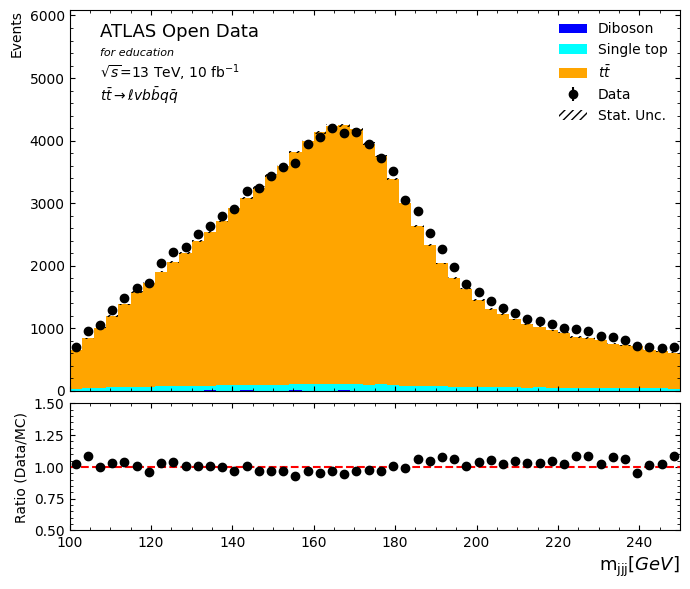

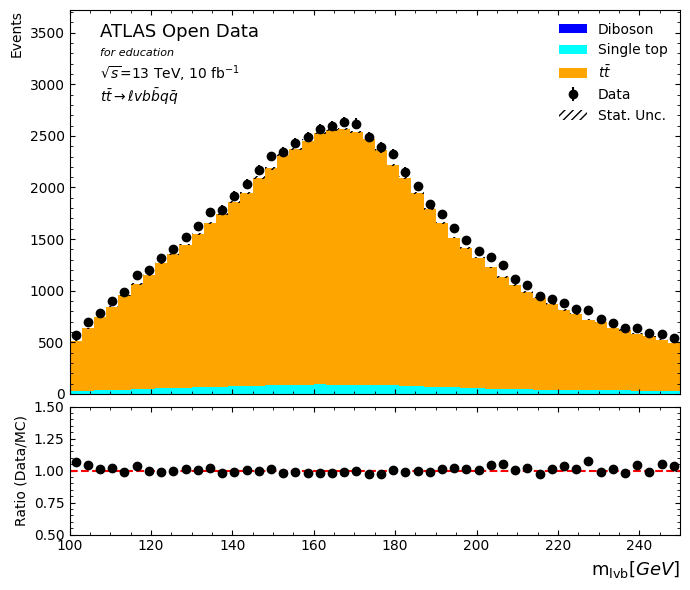

In [20]:
# Plot the trijet mass distribution (m_jjj)
plot_data(ak.Array(main_analysis_df['mtop']),       # Main data: list of trijet masses
          ak.Array(ttbar_data_df['mtop']),          # Monte Carlo data for ttbar
          ak.Array(ttbar_data_df['Weight']),        # Weights for Monte Carlo data
          ak.Array(dilepton_data_df['mtop']),       # Diboson background data
          ak.Array(dilepton_data_df['Weight']),     # Weights for Diboson data
          ak.Array(single_top_data_df['mtop']),     # Single Top background data
          ak.Array(single_top_data_df['Weight']),   # Weights for Single Top data
          r"$\mathrm{m_{jjj}} [GeV]$",              # x-axis label: trijet mass in GeV
          False,                                    # Don't use weights for the main data
          [])                                       # Empty list for data weights (not used)

# Plot the lepton-neutrino-b-jet mass distribution (m_lvb)
plot_data(mtop2,                        # Main data: list of lepton-neutrino-b-jet masses
          mtop2_ttbar,                  # Monte Carlo data for ttbar
          weights_ttbar,                # Weights for Monte Carlo data
          mtop2_Di,                     # Diboson background data
          weights_Di,                   # Weights for Diboson data
          mtop2_ST,                     # Single Top background data
          weights_ST,                   # Weights for Single Top data
          r"$\mathrm{m_{lvb}} [GeV]$",  # x-axis label: lepton-neutrino-b-jet mass in GeV
          True,                         # Use weights for the main data
          weights_data)                 # Weights for the main data